In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import wfdb

In [2]:
def parabola(a,n,r):
    assert n>2*r
    y = np.zeros(n, dtype = np.float32)
    x = np.array(range(2, 2 * r+1))
    for i in a:
        if i > r-1 and i <= n-r:
            # y[i-r-1:i+r+1] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
            y[i-r+1:i+r] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
        elif i < r:
            y[:i+r] = ((r+1)**2-(x[r-i-1:]-r-1)**2)/(r+1)**2
        elif i<n:
            y[i-r+1:] = ((r+1)**2-(x[:r-1+(n-i)]-r-1)**2)/(r+1)**2
    return y

In [5]:
def selectFromSignal(signal, seqL, ninputs, numChan=2):
    """ 
    seqL:  number of timesteps to be used in recurrent nn
    ninput : is number of inputs in each timestep
    """
    segmentL  = seqL * ninputs; print(segmentL)
    inpOutSegment = tf.random_crop(signal, [numChan, segmentL])
    inputs = inpOutSegment[0, :]
    target = inpOutSegment[1, :]
    return inputs, target

def selectFromSignals(signals, seqL, ninputs, numChan=3):
    file_idx = np.random.randint(0, signals.shape[0]) 
#     signal = signals[file_idx, :, :]
    
    segmentL  = seqL * ninputs
    inpOutSegment = tf.random_crop(signals[file_idx, :, :], [numChan, segmentL])
#   inpOutSegment = tf.random_crop(signals[file_idx, :, 100:], [numChan, segmentL])

    inputs = inpOutSegment[0:2, :]
    target = inpOutSegment[2, :]
    print(inputs.shape, target.shape)
    return inputs, target


((462600,), (462600,))

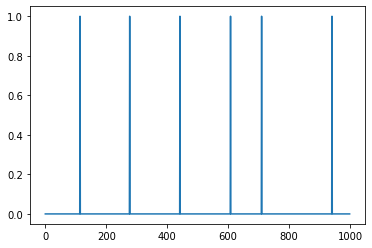

In [6]:
record = wfdb.rdrecord('train/I01', channels=[1, 6])
annotation = wfdb.rdann('train/I01', 'atr')

signals = record.__dict__['p_signal']
channel_ii = signals[:, 0]
channel_v1 = signals[:, 1]

ticks = annotation.__dict__['sample']
symbols = annotation.__dict__['symbol']

ticks_signal = np.zeros(channel_ii.shape)
ticks_signal[ticks] = 1.0
plt.plot(ticks_signal[:1000])

channel_ii.shape, channel_v1.shape

### Preprocessing

In [7]:
def removeBaseline(signal,fs):
    baseline = np.convolve(signal, np.ones(fs)/fs, mode = 'same')
    signalFinal = signal-baseline
    return signalFinal,baseline

In [8]:
record = wfdb.rdrecord('train/I01', channels=[1, 6])
annotation = wfdb.rdann('train/I01', 'atr')
signals = record.__dict__['p_signal']

N = signals.shape[0]
fs = record.__dict__['fs']
p_param = 10

import os
filenames = np.unique(list(map(lambda x : x.split('.')[0], os.listdir('train'))))
qrsAnnot = ['N','L','R','B','A','a','J','S','V','r','F','e','j','n','E','/','f','Q',' ?']

all_data = np.zeros((len(filenames), signals.shape[1]+1, N), dtype=np.float32)
idx = 0

for f in filenames[:5]:
    path = 'train/{}'.format(f)
    # read annotation
    annotation = wfdb.rdann(path, 'atr')
    uniq_symbols = np.unique(annotation.__dict__['symbol'])
    
    # check if all symbols can be found in qrsAnnot list
    if not np.all([(symbol in qrsAnnot) for symbol in uniq_symbols]):
        print("! Skipping {}...".format(f))
        continue
    
    # read signals
    record = wfdb.rdrecord(path, channels=[1, 6])
    signals = record.__dict__['p_signal']
        
    # get channel II and V1
    channel_ii = signals[:, 0]
    channel_v1 = signals[:, 1]
    
    # remove baselines
    chii_data_filter, _ = removeBaseline(channel_ii, fs)
    chv1_data_filter, _ = removeBaseline(channel_v1, fs)
    
    # reshape to  -> (1, 462600)
    chii_data_filter = chii_data_filter.reshape((1, -1))
    chv1_data_filter = chv1_data_filter.reshape((1, -1))
    
    # put two signals together -> (2, 462600)
    signal = np.concatenate((chii_data_filter, chv1_data_filter), axis=0)

    # get ticks and create parabola
    ticks = annotation.__dict__['sample']
    if np.any(ticks < 0):
        print("! Negative ticks in ", f)
        ticks = ticks[1:]
    
    p = parabola(ticks, N, p_param)
    
    targets = p.reshape((1, -1))
    
    # create data with signals on data[0], data[1] and ticks on data[2]
    data = np.concatenate((signal, targets), axis=0)
    
    all_data[idx] = data
    idx += 1
    print("Loaded ", f)

all_data = all_data[:idx]
print(all_data.shape)

Loaded  I01
Loaded  I02
Loaded  I03
! Negative ticks in  I04
Loaded  I04
Loaded  I05
(5, 3, 462600)


In [9]:
record = wfdb.rdrecord('test/100')
annotation = wfdb.rdann('test/100', 'atr')
signals = record.__dict__['p_signal']

N = signals.shape[0]
fs = record.__dict__['fs']
p_param = 10

import os
filenames = np.unique(list(map(lambda x : x.split('.')[0], os.listdir('test'))))
qrsAnnot = ['N','L','R','B','A','a','J','S','V','r','F','e','j','n','E','/','f','Q',' ?']

test_data = np.zeros((len(filenames), signals.shape[1]+1, N), dtype=np.float32)
idx = 0

for f in filenames[:5]:
    path = 'test/{}'.format(f)
    # read annotation
    annotation = wfdb.rdann(path, 'atr')
    uniq_symbols = np.unique(annotation.__dict__['symbol'])
    
    # check if all symbols can be found in qrsAnnot list
    # ... skipped?
    
    # read signals
    record = wfdb.rdrecord(path)
    signals = record.__dict__['p_signal']
        
    # get channel II and V1
    channel_ii = signals[:, 0]
    channel_v1 = signals[:, 1]
    
    # remove baselines
    chii_data_filter, _ = removeBaseline(channel_ii, fs)
    chv1_data_filter, _ = removeBaseline(channel_v1, fs)
    
    # reshape to  -> (1, 462600)
    chii_data_filter = chii_data_filter.reshape((1, -1))
    chv1_data_filter = chv1_data_filter.reshape((1, -1))
    
    # put two signals together -> (2, 462600)
    signal = np.concatenate((chii_data_filter, chv1_data_filter), axis=0)

    # get ticks and create parabola
    ticks = annotation.__dict__['sample']
    if np.any(ticks < 0):
        print("! Negative ticks in ", f)
        ticks = ticks[1:]
#         ticks[ticks < 0] = 0.0
    
    p = parabola(ticks, N, p_param)
    
    targets = p.reshape((1, -1))
    
    # create data with signals on data[0], data[1] and ticks on data[2]
    data = np.concatenate((signal, targets), axis=0)
    
    test_data[idx] = data
    idx += 1
    print("Loaded ", f)

test_data = test_data[:idx]
print(test_data.shape)

Loaded  100
Loaded  101
Loaded  102
Loaded  103
Loaded  104
(5, 3, 650000)


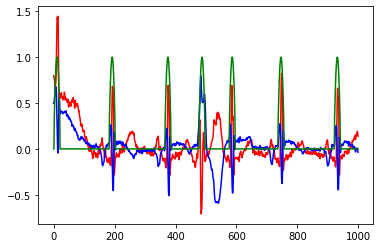

In [10]:
sig = all_data[1, :, :]
x = np.arange(sig.shape[1])

plt.plot(x[:1000], sig[0, :1000], 'r', x[:1000], sig[1, :1000], 'b', x[:1000], sig[2, :1000], 'g')

### Parameters

In [11]:
window_size = 250
p_param = 10
seqL = 20
fs = 257
ninputs = int(0.05*fs) 
batchSize = 8
testDataSize = 62600
val_perc = 0.15

(650000,)


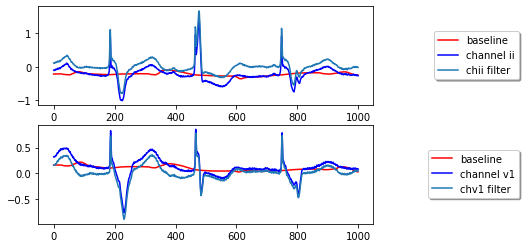

In [12]:
print(channel_ii.shape)

chii_data_filter,baseline_chii = removeBaseline(channel_ii,fs)
chv1_data_filter,baseline_chv1 = removeBaseline(channel_v1,fs)
x = range(1000)

plt.figure(1)
plt.subplot(211)
plt.plot(x,baseline_chii[1000:2000], 'r',x,channel_ii[1000:2000],'b',x,chii_data_filter[1000:2000])
plt.legend(('baseline', 'channel ii', 'chii filter'),
           loc='upper right', bbox_to_anchor=(1.45, 0.8),shadow=True, ncol=1)

plt.subplot(212)
plt.plot(x,baseline_chv1[1000:2000], 'r',x,channel_v1[1000:2000],'b',x,chv1_data_filter[1000:2000])

plt.legend(('baseline', 'channel v1', 'chv1 filter'),
           loc='upper right', bbox_to_anchor=(1.45, 0.8),shadow=True, ncol=1)
plt.show()

In [13]:
trainData = all_data
testData = test_data

# train validation split
valData = trainData[:, :, :int(trainData.shape[2]*val_perc)]
trainData = trainData[:, :, int(trainData.shape[2]*val_perc):]

print(trainData.shape, valData.shape, testData.shape)

# training data
trainData = tf.data.Dataset.from_tensors(trainData)
trainData = trainData.map(lambda x:  selectFromSignals(x, seqL, ninputs))
trainData = trainData.repeat()  # Repeat the input indefinitely.
trainData = trainData.batch(batchSize)

# validation data
valData = tf.data.Dataset.from_tensors(valData)
valData = valData.map(lambda x:  selectFromSignals(x, seqL, ninputs))
valData = valData.repeat()  # Repeat the input indefinitely.
valData = valData.batch(batchSize)

# test data
testData = tf.data.Dataset.from_tensors(testData)
testData = testData.map(lambda x:  selectFromSignals(x, seqL, ninputs))
testData = testData.repeat()  # Repeat the input indefinitely.
testData = testData.batch(batchSize)


(5, 3, 393210) (5, 3, 69390) (5, 3, 650000)
Instructions for updating:
Colocations handled automatically by placer.
(2, 240) (240,)
(2, 240) (240,)
(2, 240) (240,)


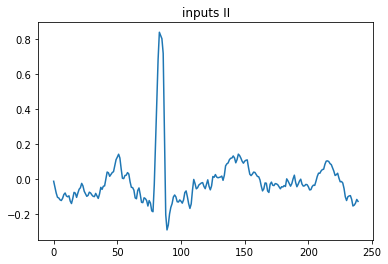

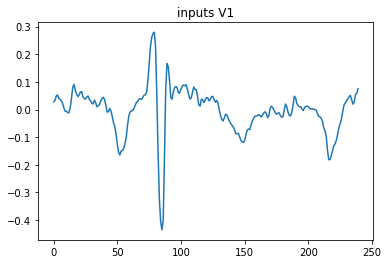

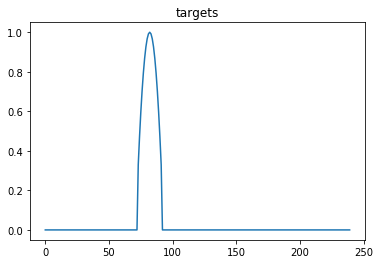

In [14]:
# let's visualize the model's input data and target data
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
    
plt.plot(inp[0,0,:])
plt.title('inputs II')
plt.show()
plt.plot(inp[0,1,:])
plt.title('inputs V1')
plt.show()
plt.plot(targ[0,:])
plt.title('targets')
plt.show()

In [15]:
from tensorflow.python.keras import layers

ffwdModel = tf.keras.Sequential()
ffwdModel.add(layers.Dense(64, activation='relu', input_shape=(2,seqL*ninputs)))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Flatten())
ffwdModel.add(layers.Dense(seqL * ninputs))
ffwdModel.summary()

ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModel.fit(trainData, epochs=5, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 64)             15424     
_________________________________________________________________
dense_1 (Dense)              (None, 2, 64)             4160      
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 240)               30960     
Total params: 50,544
Trainable params: 50,544
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1000/1000 [==============================] - 17s 17ms/step - loss: 0.0400 - mean_absolute_error: 0.1169 - val_loss: 0.0292 - val_mean_absolute_error: 0.1128
Epoch 2

500/500 [==============================] - 2s 3ms/step - loss: 0.1882 - mean_absolute_error: 0.3179
test mean square error (loss):  0.1882250386327505   test absolute error:  0.31790856


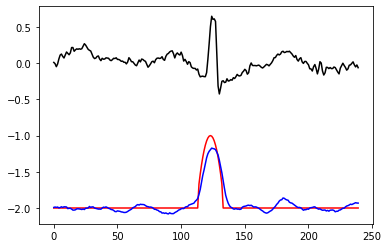

In [16]:
out = ffwdModel.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModel.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,0,:],'k',t,targ[0]-2,'r',t,output[0]-2,'b')
plt.show()

In [17]:
np.random.seed(3)

seqL = 20
ninputs = 12
window = seqL*ninputs

selected = all_data[2, :, :]
inputs = selected[0:2, :]
targets = selected[2, :]

numChan = 2
start_idx = np.random.randint(0, inputs.shape[1] - window)
crop = inputs[:, start_idx : start_idx+window]

crop = transform_to_timesteps(crop, seqL=20).shape

NameError: name 'transform_to_timesteps' is not defined

In [106]:
def transform_to_timesteps(arr, seqL=20):
    ninputs = int( int(arr.shape[1]) / seqL)
    nchannels = arr.shape[0]
    
    arr = arr.T.reshape(seqL, ninputs, nchannels)
    
    new_arr = np.zeros((seqL, nchannels, ninputs), dtype=np.float32)
    for i in range(seqL):
        new_arr[i] = arr[i].T
    
    return new_arr
 
arr = np.arange(1, 481, dtype=np.float32)
arr = arr.reshape(2, -1)
print(arr.shape)

new_arr = transform_to_timesteps(arr, seqL=20)
new_arr.shape

(2, 240)


(20, 2, 12)

In [19]:
import tensorflow as tf
sess = tf.InteractiveSession()

arr = np.arange(1, 25, dtype=np.float32)
arr = arr.reshape(2, -1)
c = tf.constant(arr)

# c = tf.reshape(c, (3, 4, 2))
c = tf.transpose(c)
c = tf.reshape(c, (3, 4, 2))
# print(c.shape)
c = tf.transpose(c, perm=[0,2,1])

c.eval()

C:\Users\julka\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


array([[[ 1.,  2.,  3.,  4.],
        [13., 14., 15., 16.]],

       [[ 5.,  6.,  7.,  8.],
        [17., 18., 19., 20.]],

       [[ 9., 10., 11., 12.],
        [21., 22., 23., 24.]]], dtype=float32)

In [20]:
def selectFromSignals_LSTM(signals, seqL, ninputs, numChan=3):
    file_idx = np.random.randint(0, signals.shape[0]) 
    signal = signals[file_idx, :, :]
    
    segmentL  = seqL * ninputs
    inpOutSegment = tf.random_crop(signal, [numChan, segmentL])

    inputs = inpOutSegment[0:2, :]
    target = inpOutSegment[2, :]
    
    inputs = tf.transpose(inputs)
    inputs = tf.reshape(inputs, (seqL, ninputs, 2))
    inputs = tf.transpose(inputs, perm=[0,2,1])
    
    print(inputs.shape, target.shape)
    return inputs, target

In [29]:
trainData = all_data
testData = test_data

# train validation split
valData = trainData[:, :, :int(trainData.shape[2]*val_perc)]
trainData = trainData[:, :, int(trainData.shape[2]*val_perc):]

print(trainData.shape, valData.shape, testData.shape)

# training data
trainData = tf.data.Dataset.from_tensors(trainData)
trainData = trainData.map(lambda x:  selectFromSignals_LSTM(x, seqL, ninputs))
trainData = trainData.repeat()  # Repeat the input indefinitely.
# trainData = trainData.batch(batchSize)

# validation data
valData = tf.data.Dataset.from_tensors(valData)
valData = valData.map(lambda x:  selectFromSignals_LSTM(x, seqL, ninputs))
valData = valData.repeat()  # Repeat the input indefinitely.
# valData = valData.batch(batchSize)

# test data
testData = tf.data.Dataset.from_tensors(testData)
testData = testData.map(lambda x:  selectFromSignals_LSTM(x, seqL, ninputs))
testData = testData.repeat()  # Repeat the input indefinitely.
# testData = testData.batch(batchSize)

(5, 3, 393210) (5, 3, 69390) (5, 3, 650000)
(20, 2, 12) (240,)
(20, 2, 12) (240,)
(20, 2, 12) (240,)


In [33]:
x = np.arange(5)
x = x.reshape(-1, 1)
x.shape

(5, 1)

In [37]:
numLstmUnits = 32
denseDim = ninputs
ffwdModelSequential = tf.keras.Sequential()

# ffwdModelSequential.add(layers.Reshape((seqL,ninputs), input_shape=(seqL*ninputs,)))

ffwdModelSequential.add(layers.LSTM(32, input_shape=(2, ninputs), return_sequences=True))
# ffwdModelSequential.add(layers.LSTM(32, return_sequences=True))

# ffwdModelSequential.add(layers.TimeDistributed(layers.Dense(denseDim)))
ffwdModelSequential.add(layers.Flatten())

ffwdModelSequential.add(layers.Dense(seqL * ninputs))

# ffwdModelSequential.add(layers.Dense(seqL*ninputs))

ffwdModelSequential.add(layers.Reshape((seqL * ninputs, 1)))

# ffwdModelSequential.add(layers.TimeDistributed(layers.Dense(denseDim)))

ffwdModelSequential.summary()


'''
rnnModel.add(layers.Reshape((seqL, ninputs), input_shape=(seqL*ninputs,)))
rnnModel.add(layers.LSTM(units=numLstmUnits, return_sequences=True))         
rnnModel.add(layers.LSTM(units=numLstmUnits, return_sequences=True))
rnnModel.add(layers.TimeDistributed(layers.Dense(denseDim)))
rnnModel.add(layers.Reshape((seqL*ninputs,)))
'''

ffwdModelSequential.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModelSequential.fit(trainData,  epochs=10, steps_per_epoch=1000, validation_data=trainData, validation_steps=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 2, 32)             5760      
_________________________________________________________________
flatten_11 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 240)               15600     
_________________________________________________________________
reshape_1 (Reshape)          (None, 240, 1)            0         
Total params: 21,360
Trainable params: 21,360
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0599 - mean_absolute_error: 0.1119 - val_loss: 0.0595 - val_mean_absolute_error: 0.1257
Epoch 2/10
 669/1000 [===================>..........] - ETA: 2s - loss: 0.0602 - mean_absolute_error: 

KeyboardInterrupt: 

In [ ]:
ffwdModelSequential.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
out = ffwdModelSequential.evaluate(testData, steps=500)
print('test mean square error (loss): ', out[0], '  test absolute error: ', out[1])
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
output = ffwdModelSequential.predict(inp)
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0],'r',t,output[0],'b')
plt.show()

In [ ]:
t = range(seqL*ninputs)
plt.plot(t,inp[0,:],'k',t,targ[0],'r',t,output[0],'b')
plt.show()